## Week2. Optimization Problems & Rydberg Atom Arrays - Additional Challenge 1

-----

We demonstrate the benchmarking of two method, classical simulated annealing and quantum annealing on the Rydberg atom
arrays. The testbeds are sets of cities near Cape Town, Tokyo, New York and Toronto.

Starting from the imports and loading the precalculated results:

In [23]:
import pickle

from Week2_Rydberg_Atoms.draw_graph import draw_graph, draw_multi_graph
from Week2_Rydberg_Atoms.utils import int_to_bin, sanity_check

with open('./simulations/city_example_QA.txt', 'rb') as of:
    simulation_result_dt = pickle.load(of)
with open('./simulations/city_example_QA_2.txt', 'rb') as of:
    simulation_result_T = pickle.load(of)
with open('./city_example_dataset.txt', 'rb') as of:
    city_graph = pickle.load(of)

We loaded and filtered the sets of cities from the [online datatset](https://simplemaps.com/data/world-cities),
extracting the latitudes, longitudes, population, and the nation that the each city belongs to.

The python script `./save_city.py` demonstrates how we filtered the cities and generated the `./city_example_dataset.txt`.

South Africa Near Cape Town , Pop >  1,000
6 cities


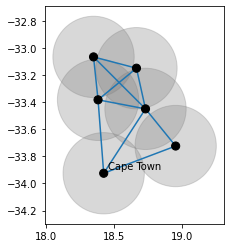

United States, Near New York , Pop >  200,000
10 cities


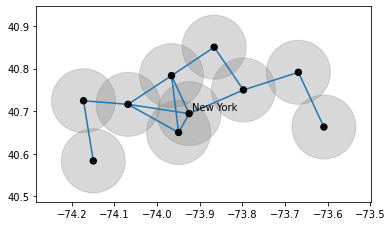

Japan, Near Tokyo , Pop >  400,000
13 cities


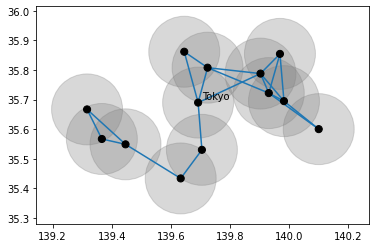

Canada, Near Toronto , Pop >  50,000
17 cities


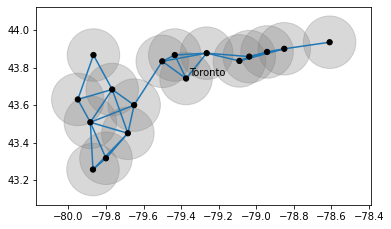

In [24]:
# Sorted by the number of vertices
sorted_key = sorted(list(city_graph.keys()), key=lambda x: len(city_graph[x]['graph']))[:-2]
main_city_name = ['Toronto', 'New York', 'Tokyo', 'Cape Town']
for city_set in sorted_key:
    labeling = [s if s in main_city_name else "" for s in city_graph[city_set]['names']]
    graph = city_graph[city_set]['graph']
    radius = city_graph[city_set]['radius']
    num_cities = len(graph)
    print(f"{city_set.split('>')[0]}, Pop > {city_set.split('>')[1]}")
    print(f"{num_cities} cities")
    draw_graph(graph, radius=radius, texts=labeling)


Before we demonstrate the all simulation results, let's focus on the Toronto case.
In the default setting, `T = 1.0` and `dt = 0.001`, we found 10 most frequent solutions as below.

In [25]:
dataset_name = 'Canada, Near Toronto > 50,000'
result_by_dt = simulation_result_dt[dataset_name]
graph = city_graph[dataset_name]['graph']
radius = city_graph[dataset_name]['radius']
num_cities = len(graph)
print(city_graph[dataset_name]['names'])

['Toronto', 'Mississauga', 'Hamilton', 'Brampton', 'Markham', 'Vaughan', 'Richmond Hill', 'Oakville', 'Burlington', 'Oshawa', 'Whitby', 'Ajax', 'Milton', 'Clarington', 'Pickering', 'Caledon', 'Halton Hills']


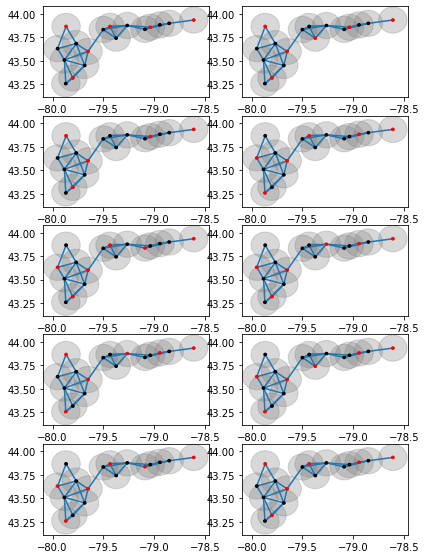

In [26]:
occurrence = result_by_dt[0.001]['occurrence']
ans_bool = [int_to_bin(a, num_cities) for a in occurrence][:10]
draw_multi_graph(graph,
                 radius=radius,
                 answer_list=ans_bool,
                 texts=["" for _ in range(num_cities)])


Assuming the number of vertices of the solution is 6, we can see there are 9 solutions shown here.
Let's look at the entire observations.

In [27]:
max_finding = 6
solutions_list = []
violated = 0
suboptimal = 0
solution = 0

occurrence = result_by_dt[0.001]['occurrence']
for a in occurrence:
    a_bin = int_to_bin(a, num_cities)
    v, n = sanity_check(graph, radius=radius, answer=a_bin)
    if v > 0:
        violated += occurrence[a]
    elif v == 0 and n < max_finding:
        suboptimal += occurrence[a]
    elif v == 0 and n == max_finding:
        solution += occurrence[a]
        solutions_list.append(a_bin)
    else:
        print("unexpected")
        print(v, n, max_finding)
        raise ValueError
nshots = solution + suboptimal + violated
print(f"probability to find obtimal answers    : {solution / nshots}")
print(f"probability to find invalid answers    : {violated / nshots}")
print(f"probability to find suboptimal answers : {suboptimal / nshots}")
print(f"There are {len(solutions_list)} solutions")

probability to find obtimal answers    : 0.7621
probability to find invalid answers    : 0.1105
probability to find suboptimal answers : 0.1274
There are 28 solutions


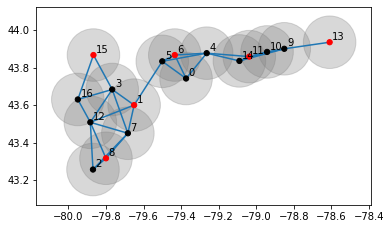

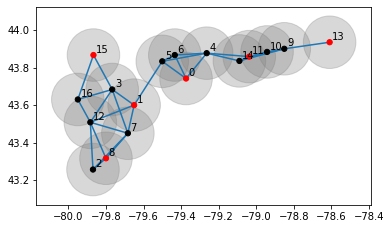

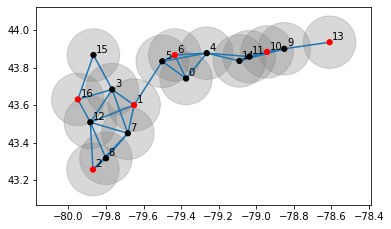

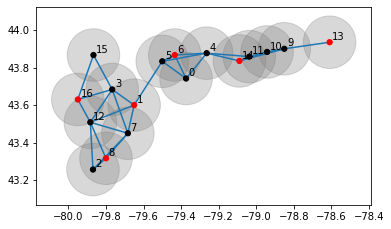

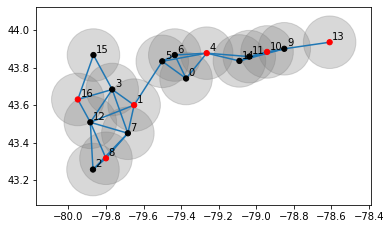

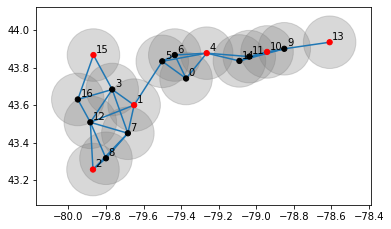

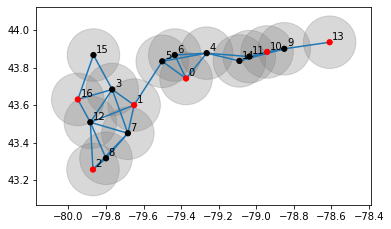

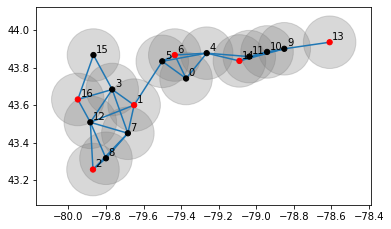

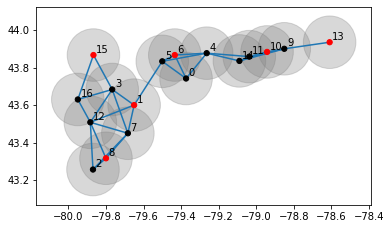

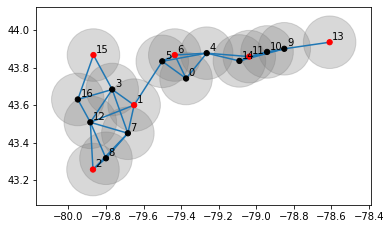

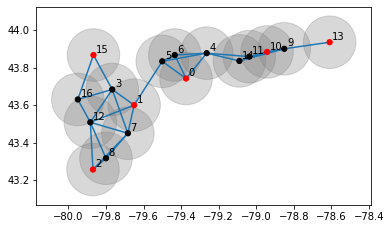

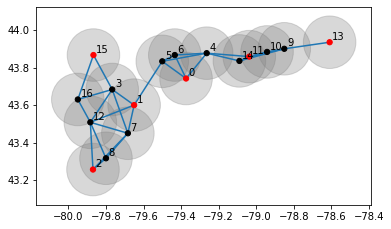

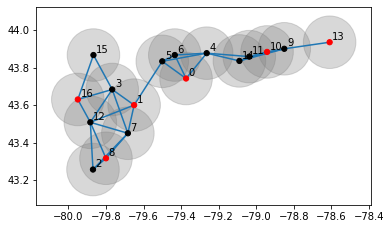

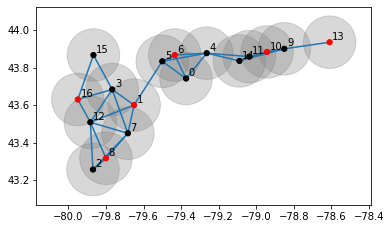

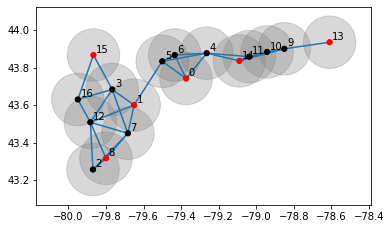

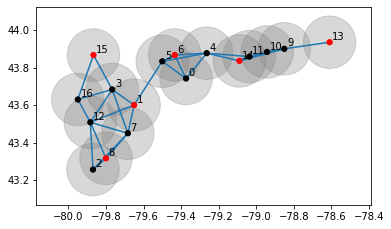

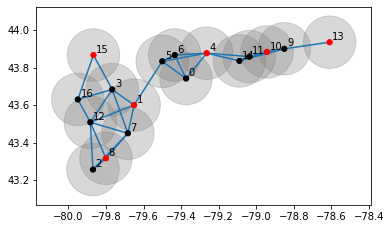

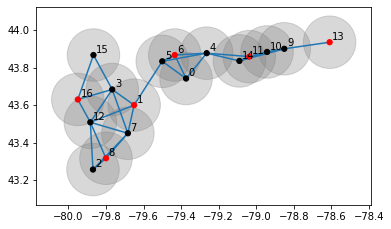

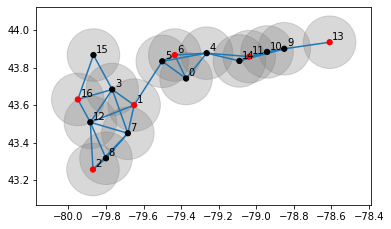

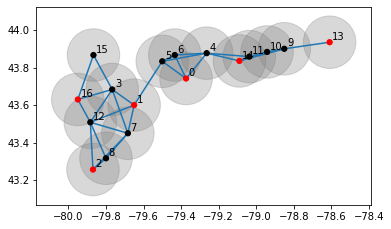

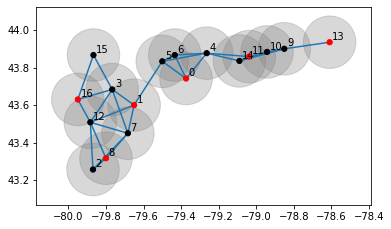

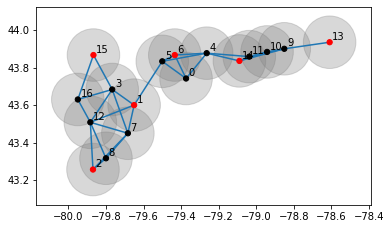

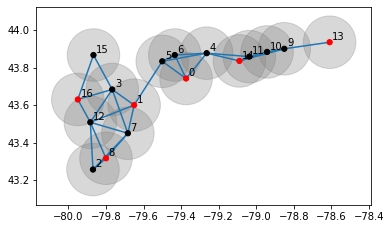

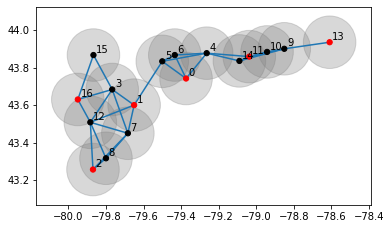

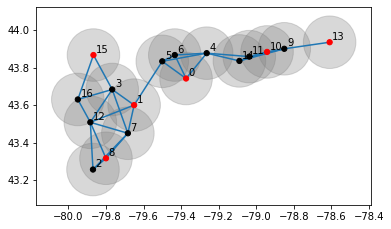

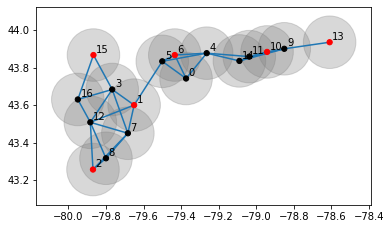

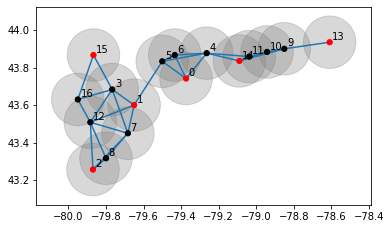

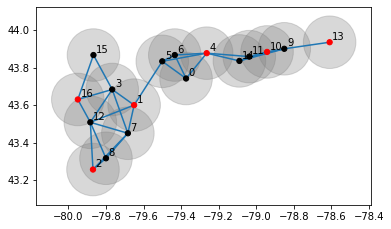

In [29]:
for sol in solutions_list:
    draw_graph(graph, radius=radius, answer=sol)